In [20]:
import networkx as nx

filename = "data/out.dimacs10-celegansneural"

def OpenNetwork(filename, digraph=True): 
    G = nx.DiGraph()

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith("%"):
                source, target, capacity = line.split()
                source = int(source)
                target = int(target)
                capacity = int(capacity)
                G.add_edge(source, target, capacity=capacity)
    if digraph:
        return G
    else:
        return G.to_undirected()
        

In [56]:
import numpy as np
import networkx as nx

def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M

# Calcula algumas medidas de redes complexas
def network_measures(G):    
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = k2 - k1**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1, k2, variance, av_cl, l, r


In [22]:
import numpy as np
import gudhi

# Calcula números de Betti da rede
def betti_numbers(G):
    # Obter a lista de cliques para cada rede
    cliques = list(nx.enumerate_all_cliques(G))

    # Criar o complexo simplicial a partir das listas de cliques
    complex = gudhi.SimplexTree()
    for clique in cliques:
        complex.insert(clique)

    # Calcula homologia do complexo simplicial
    complex.persistence(homology_coeff_field=2, min_persistence=-1.0, persistence_dim_max=True)

    # Retorna números de Betti da homologia calculada
    betti_num = complex.betti_numbers()
    
    # homogenização do tamanho do vetor a ser retornado
    vector_len = 5
    betti_num = betti_num[:vector_len]
    if (len(betti_num) < vector_len):
        betti_num = np.pad(betti_num, (0, vector_len - len(betti_num)), mode='constant')
    
    return betti_num

network_measures= (14.464646464646465, 376.7811447811448, 167.5551474339353, 0.29236329783219006, 2.455318955318955, -0.16319921031570375)
betti_numbers= [1, 139, 121, 4, 0]


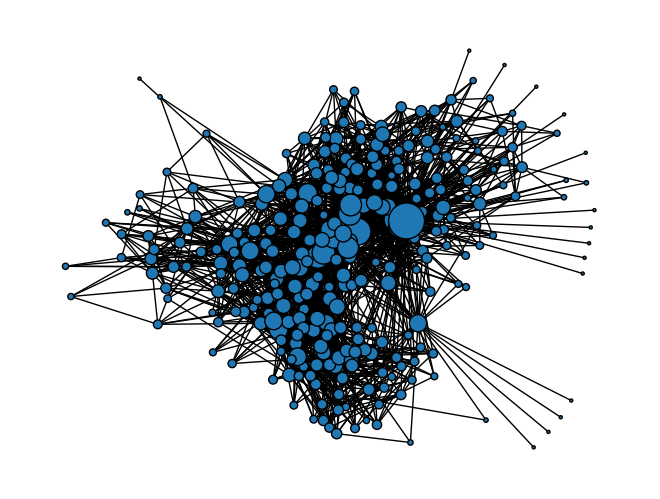

In [45]:
G = OpenNetwork(filename, digraph=False)
pos = nx.spring_layout(G, seed=42)
d = dict(G.degree())
nx.draw(G, pos, node_size=[v * 5 for v in d.values()], edgecolors='black', with_labels=False)
print("network_measures=", network_measures(G))
print("betti_numbers=", betti_numbers(G))

In [38]:
import numpy as np
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Criar as redes complexas e calcular as medidas e os números de Betti correspondentes
X = []
y = []

for i in range(100):  # Número de redes complexas
    # Criar um grafo usando a biblioteca NetworkX
    G = nx.erdos_renyi_graph(100, 0.1)  # Exemplo de criação de um grafo ER aleatório

    # Calcular as medidas usuais de redes complexas
    measures = network_measures(G)

    # Adicionar as medidas à lista X
    X.append(measures)

    y.append(betti_numbers(G)[1])

# Converter X e y em arrays numpy
X = np.array(X)
y = np.array(y)

# Dividir os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciar o modelo Random Forest
model = RandomForestClassifier()

# Treinar o modelo com o conjunto de treinamento
model.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(y_test)
print(y_pred)
print("Acurácia do modelo:", accuracy)

[235 229 235 245 251 237 255 241 241 247 239 242 241 239 249 254 237 257
 253 249]
[231 231 243 244 244 243 244 254 231 243 253 233 245 241 244 248 232 251
 244 244]
Acurácia do modelo: 0.0


number of nodes=297 average degree=14.464646464646465
Classe: BA
Classe: BA
Classe: BA
Classe: BA


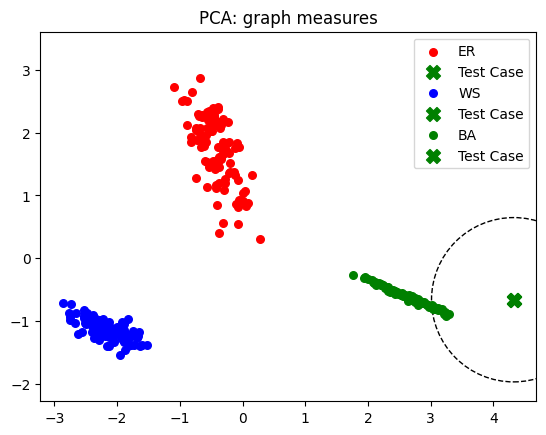

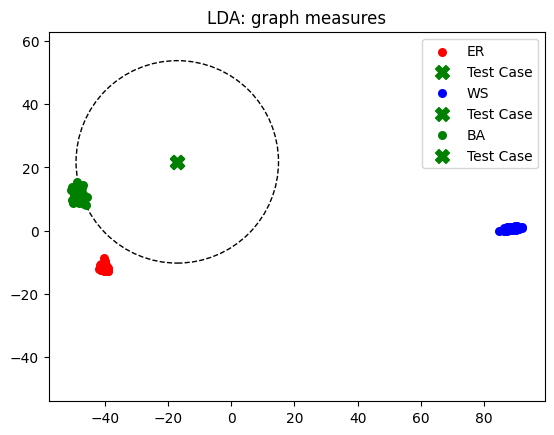

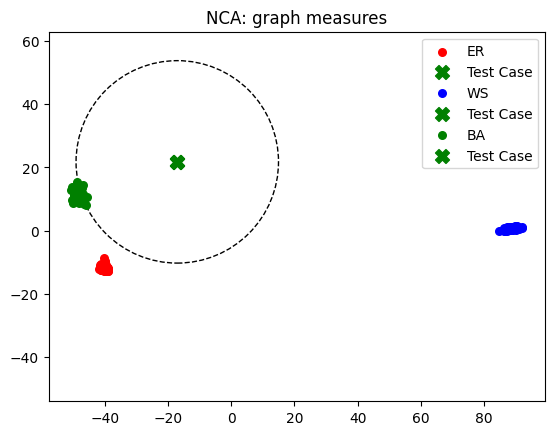

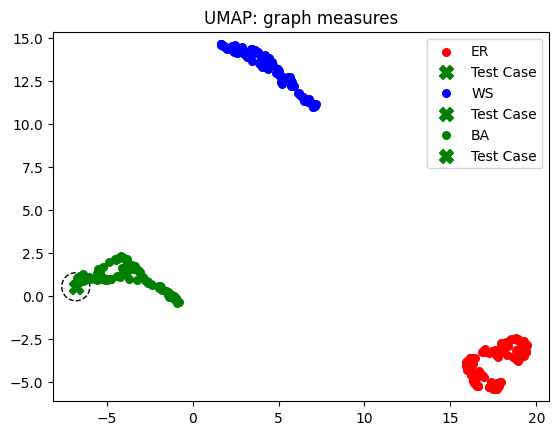

Classe: BA
Classe: BA
Classe: BA
Classe: WS


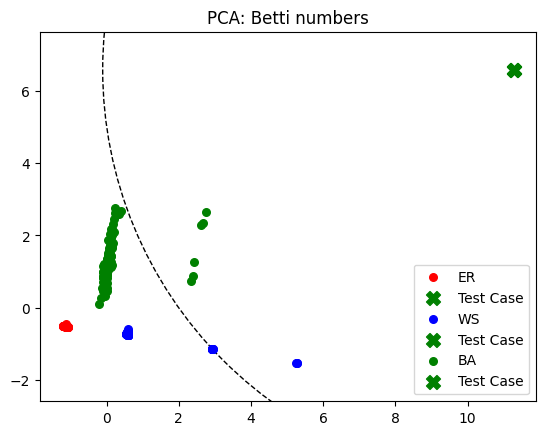

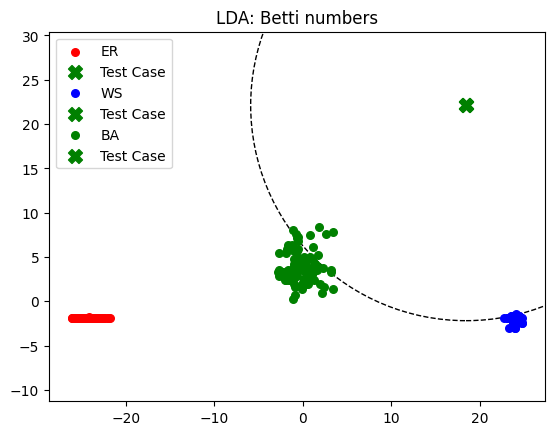

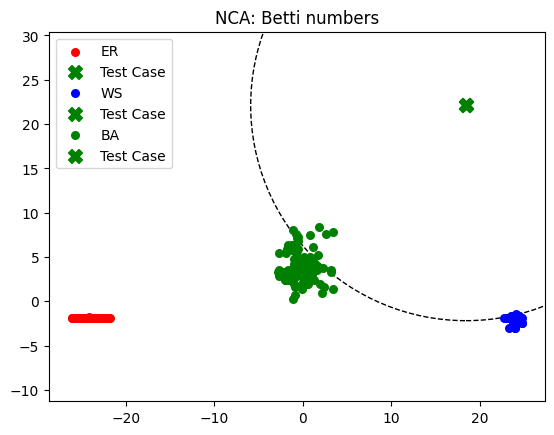

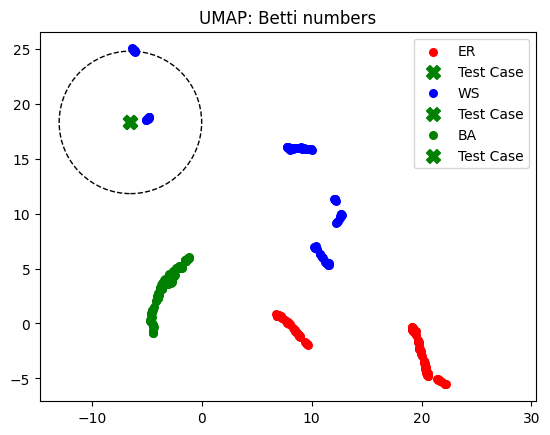

In [62]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import umap

# Parâmetros de simulação
n_nets = 100  # Quantidade de redes
n_nodes = len(G)  # Quantidade de vértices
av_degree = momment_of_degree_distribution(G, 1) # Grau médio

print(f"number of nodes={n_nodes} average degree={av_degree}")

# Vetores para impressão de resultados
X_measures = []
X_betti_num = []
y = []

#ER networks
p = av_degree/(n_nodes-1)
for i in range(0,n_nets):
    GER = nx.gnp_random_graph(n_nodes, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    k1,k2,variance,av_cl,l,r = network_measures(GER)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    x = betti_numbers(GER)
    X_betti_num.append(x)
    y.append(0)

#WS networks
k = int(av_degree)
p = 0.05 #probability of rewiring
for i in range(0,n_nets):
    GWS = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    k1,k2,variance,av_cl,l,r = network_measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    x = betti_numbers(GWS)
    X_betti_num.append(x)
    y.append(1)

# BA networks
m = int(av_degree/2)
for i in range(0,n_nets):
    GBA = nx.barabasi_albert_graph(n_nodes, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    k1,k2,variance,av_cl,l,r = network_measures(GBA)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    x = betti_numbers(GBA)
    X_betti_num.append(x)
    y.append(2)
    
y = np.array(y)

# Padroniza os recursos removendo a média e dimensionando para a variância da unidade.
scaler = StandardScaler().fit(X_measures)
X_measures = scaler.transform(X_measures)

k1,k2,variance,av_cl,l,r = network_measures(G)
X_net = [k1, k2, variance, av_cl, l, r]
X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net)) 
X_net = scaler.transform(X_net)

scaler = StandardScaler().fit(X_betti_num)
X_betti_num = scaler.transform(X_betti_num)

# Reduz para 2 dimensões com PCA Principal Component Analysis
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))

# Reduz para 2 dimensões com Linear Discriminant Analysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduz para 2 dimensões com 2 with Neighborhood Component Analysis
nca = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(n_components=2, random_state=0))

# Reduz para 2 dimensões com Uniform Manifold Approximation and Projection
uma = umap.UMAP()

dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca), ("UMAP", uma)]

cl = ['ER','WS','BA']

# Define colors for each class and for the test case
colors = ['red', 'blue', 'green' ]

n_neighbors=10
knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = 'euclidean')
 
# Plot each method's projection
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X_measures, y)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X_measures)
    
	# Embed the test case in 2 dimensions using the fitted model
    X_test_embedded = model.transform(X_net.reshape(1, -1))
  
	# Make predictions using KNN
    knn.fit(X_embedded, y)
			
	# Find the k nearest neighbors to the center point
    _, indices = knn.kneighbors(X_test_embedded, n_neighbors=k)
    neighbors = X_embedded[indices][0]
	
	# Calculate the radius of the circle
    radius = np.max(np.linalg.norm(neighbors - X_test_embedded, axis=1))
	
	# Draw a circle around the center point with the calculated radius
    circle = plt.Circle([X_test_embedded[:,0], X_test_embedded[:,1]], radius, color='black', fill=False, linestyle='dashed')
    plt.gca().add_artist(circle)
	
    y_pred = knn.predict(X_test_embedded)
		
    print('Classe:', cl[int(np.mean(y_pred))])
    
    for j in range(len(cl)):
        plt.scatter(
            X_embedded[y == j, 0],
            X_embedded[y == j, 1],
            c=colors[j],
            s=30,
            label=cl[j],
        )
    plt.scatter(
		X_test_embedded[:, 0],
		X_test_embedded[:, 1],
		c='orange',
		s=100,
		marker="X",
		label="Test Case",
    )
    plt.legend()
    plt.title(name + ": graph measures")
    plt.axis('equal')
    
plt.show()

X_net = betti_numbers(G)
X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net)) 
X_net = scaler.transform(X_net)

# Plot each method's projection
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X_betti_num, y)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X_betti_num)
    
	# Embed the test case in 2 dimensions using the fitted model
    X_test_embedded = model.transform(X_net.reshape(1, -1))
  
	# Make predictions using KNN
    knn.fit(X_embedded, y)
			
	# Find the k nearest neighbors to the center point
    _, indices = knn.kneighbors(X_test_embedded, n_neighbors=k)
    neighbors = X_embedded[indices][0]
	
	# Calculate the radius of the circle
    radius = np.max(np.linalg.norm(neighbors - X_test_embedded, axis=1))
	
	# Draw a circle around the center point with the calculated radius
    circle = plt.Circle([X_test_embedded[:,0], X_test_embedded[:,1]], radius, color='black', fill=False, linestyle='dashed')
    plt.gca().add_artist(circle)
	
    y_pred = knn.predict(X_test_embedded)
		
    print('Classe:', cl[int(np.mean(y_pred))])
    
    for j in range(len(cl)):
        plt.scatter(
            X_embedded[y == j, 0],
            X_embedded[y == j, 1],
            c=colors[j],
            s=30,
            label=cl[j],
        )
    plt.scatter(
		X_test_embedded[:, 0],
		X_test_embedded[:, 1],
		c='orange',
		s=100,
		marker="X",
		label="Test Case",
    )
    plt.legend()
    plt.title(name + ": Betti numbers")
    plt.axis('equal')
plt.show()